In [1]:
# =====================================
# 基本設定・ユーティリティ
# =====================================
import warnings
import joblib
import numpy as np
import pandas as pd

# =====================================
# 可視化
# =====================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# =====================================
# データ前処理・次元削減
# =====================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

# =====================================
# 回帰モデル・統計分析
# =====================================
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess
from patsy import dmatrix
from linearmodels.panel import PanelOLS

# 日本語フォント対応
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

# 再現性確保
import random
random.seed(42)
np.random.seed(42)

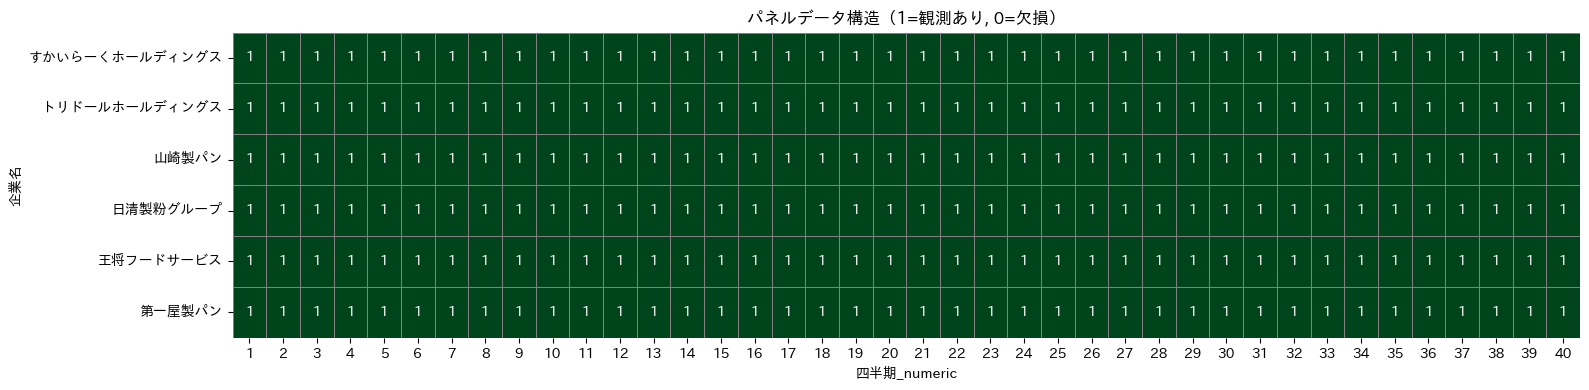

In [2]:
# ======================================================
# 0. データ読み込みと前処理（Excel → 分析用データフレーム）
# ======================================================

# --- Excelファイルをpandasで読み込む（openpyxlをエンジン指定） ---
df = pd.read_excel("パネルデータxlsx", engine="openpyxl")

# --- 列名に余計な空白が含まれる場合があるので、全てトリム（前後の空白を除去） ---
df.columns = df.columns.str.strip()

# --- 企業名列にも空白除去を適用（カテゴリ変数としての表記揺れ防止のため） ---
df["企業名"] = df["企業名"].astype(str).str.strip()

# --- 「四半期」列の文字列（"Q1"〜"Q4"）を数値（1〜4）に変換 ---
df["四半期"] = df["四半期"].replace({"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4})

# --- 年×四半期を一意な時系列番号に変換（例：2015年Q1 → 0） ---
df["四半期_numeric"] = (df["年"].astype(int) - 2015) * 4 + df["四半期"].astype(int)

# --- 処理済みデータをExcelとして保存（分析記録用） ---
df.to_excel("出力_加工済みパネルデータ.xlsx", index=False)

# ======================================================
# パネルデータのカバレッジ（欠損の有無）を可視化
# ======================================================

# パネルデータカバレッジのピボットテーブル作成
coverage = (
    df.pivot_table(
        index="企業名",
        columns="四半期_numeric",
        values="売上総利益率",
        aggfunc=lambda x: 1 if x.notnull().any() else 0,
        fill_value=0
    )
)


plt.figure(figsize=(16, 4))  # グラフの横長サイズを設定（四半期が多いため）

sns.heatmap(
    coverage,                # 企業名 × 四半期_numeric の観測マトリクス
    cmap="Greens",           # 緑色で視認性を強調
    cbar=False,              # カラーバー非表示
    linewidths=0.5,          # セルの境界線の太さ
    linecolor='gray',        # 境界線の色
    vmin=0, vmax=1,          # 色のスケールを0〜1に固定（0:欠損, 1:観測あり）
    annot=True, fmt="d"      # 各セルに「0」または「1」を明示的に表示
)

# --- グラフタイトルとラベル設定 ---
plt.title("パネルデータ構造（1=観測あり, 0=欠損）")
plt.xlabel("四半期_numeric")
plt.ylabel("企業名")
plt.tight_layout()

# --- グラフの画像として保存（PNG形式） ---
plt.savefig("出力_パネルデータ構造ヒートマップ.png", dpi=300)

# --- グラフ表示（保存後に表示） ---
plt.show()

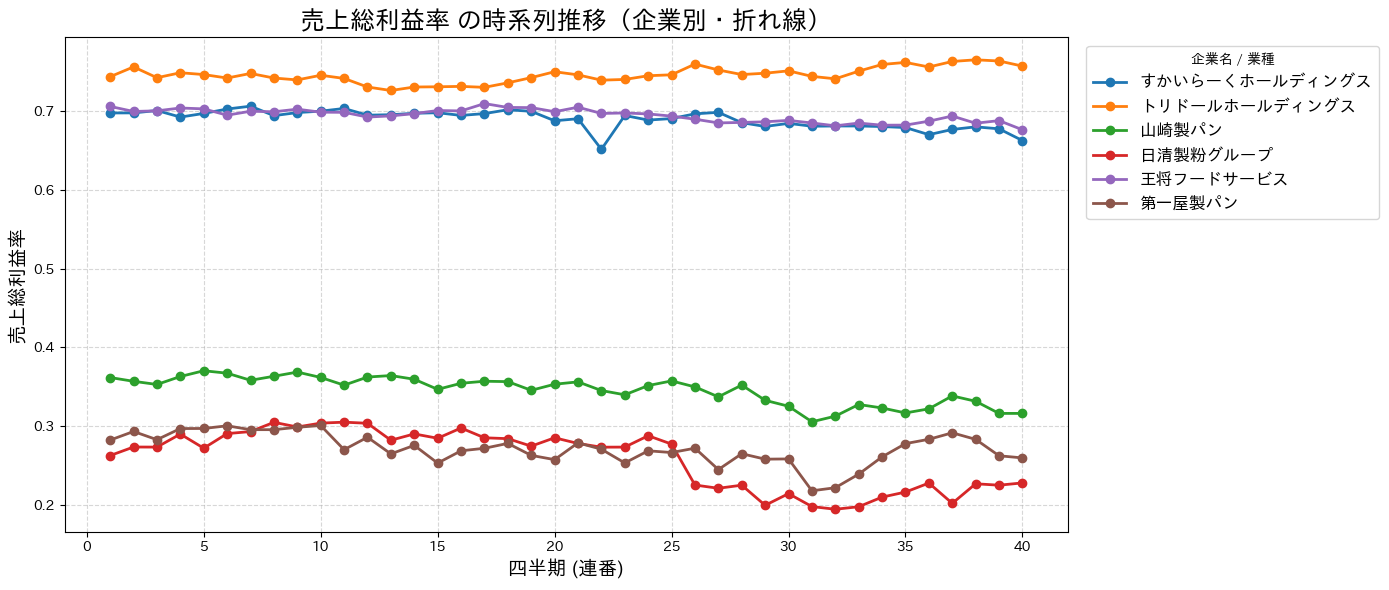

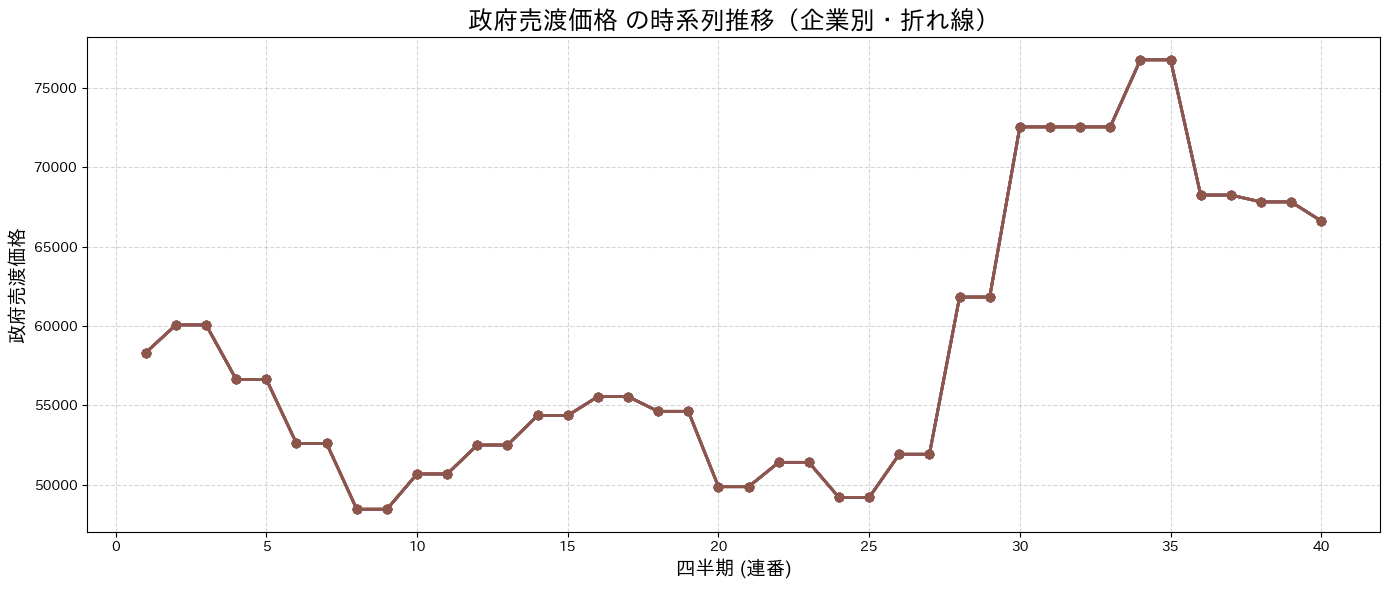

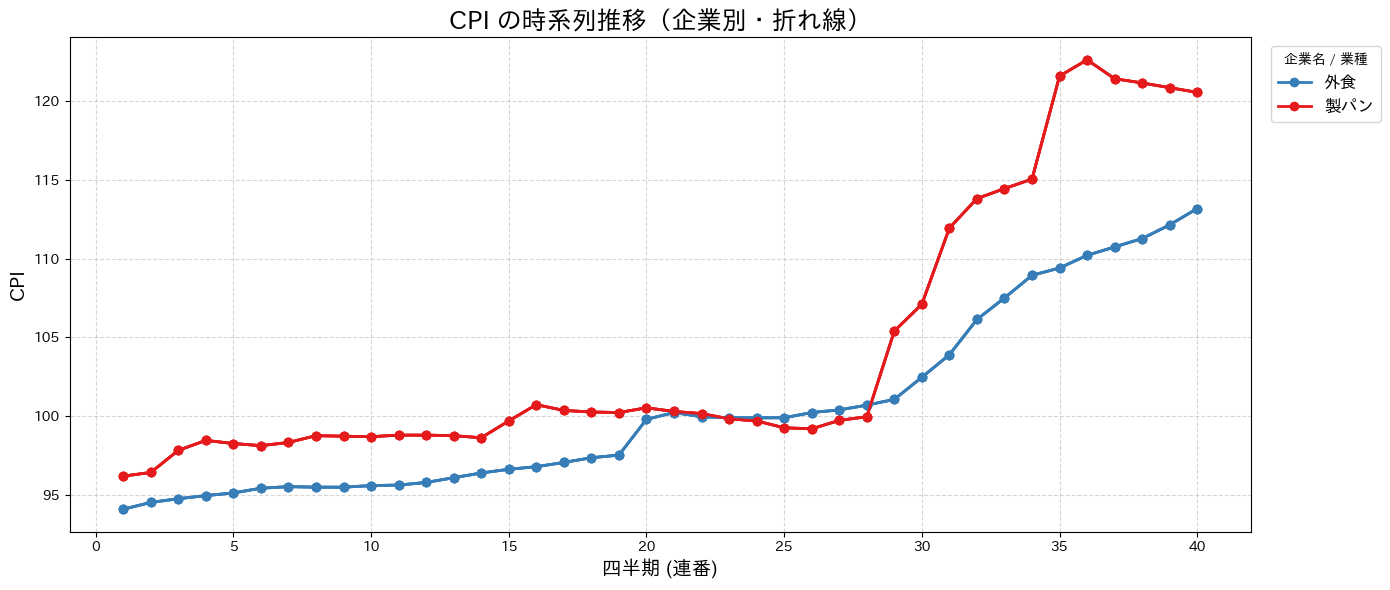

In [40]:
# ======================================================
# 1. データ構造の可視化
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 企業名一覧を取得
# → カラーパレットで企業ごとに色分けするため
# 例: ["山崎製パン", "日清製粉グループ", ...]
df_companies = df['企業名'].unique()
palette = sns.color_palette('tab10', n_colors=len(df_companies))

# CPI専用カラー設定
# 製パン(業種ダミー=0)は赤系、外食(業種ダミー=1)は青系
cpi_palette = sns.color_palette('Set1', n_colors=2)
cpi_color_map = {0: cpi_palette[0], 1: cpi_palette[1]}  # {業種ダミー値: 色}

target_vars = ['売上総利益率', '政府売渡価格', 'CPI']

for var in target_vars:
    # 各変数ごとに図を作成
    plt.figure(figsize=(14, 6))
    seen_labels = set()  # CPIの出力重複出演を防ぐ

    for idx, (company, group) in enumerate(df.groupby('企業名')):
        x = group['四半期_numeric']  # X軸
        y = group[var]               # Y軸

        # --- ラベルと線色 ---
        if var == '政府売渡価格':
            label = None
            color = palette[idx]
        elif var == 'CPI':
            industry = group['業種ダミー'].iloc[0]
            label = '製パン' if industry == 0 else '外食'
            if label in seen_labels:
                label = None
            else:
                seen_labels.add(label)
            color = cpi_color_map[industry]
        else:
            label = company
            color = palette[idx]

        # --- プロット ---
        plt.plot(
            x, y,
            marker='o',
            label=label,
            linewidth=2,
            color=color
        )

    # --- 図の設定 ---
    plt.title(f"{var} の時系列推移（企業別・折れ線）", fontsize=18)
    plt.xlabel("四半期 (連番)", fontsize=14)
    plt.ylabel(var, fontsize=14)

    if var != '政府売渡価格':
        plt.legend(title="企業名 / 業種", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"出力_企業別_{var}_折れ線推移.png", dpi=300)
    plt.show()


In [41]:
# ======================================================
# 2. 多重共線性チェック（VIF：Variance Inflation Factor）
# ======================================================

# --- 分析対象の説明変数を抽出し、欠損値を除去 ---
# 「政府売渡価格」と「CPI」の間に多重共線性（相関による冗長性）がないかを確認する
vif_df = df[["政府売渡価格", "CPI"]].dropna()

# --- 定数項（切片）を追加 ---
# 回帰モデルでは、定数項を含めることで偏りを補正するため必要
X = sm.add_constant(vif_df)

# --- 各変数について VIF を計算 ---
# VIFが5を超えると中程度、10を超えると強い多重共線性があるとされる
vif_result = pd.DataFrame({
    "変数": X.columns,  # 変数名（定数項含む）
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# --- 結果の表示 ---
print("=== 多重共線性（VIF）チェック結果 ===")
print(vif_result)

# --- 結果をCSVとして保存（分析記録・報告書への添付用） ---
vif_result.to_csv("出力_VIF結果.csv", index=False)

=== 多重共線性（VIF）チェック結果 ===
       変数         VIF
0   const  216.166723
1  政府売渡価格    2.323450
2     CPI    2.323450


# 2. 多重共線性チェック（VIF）結果
- **政府売渡価格とCPIについて、多重共線性の懸念はない**
- この2つの変数を説明変数としてモデルに入れることの正当性を確認した

=== ラグ組み合わせごとのR²（降順） ===
    政府_lag  CPI_lag        R2      政府_p     CPI_p
20       4        0  0.372533  0.001015  0.000543
15       3        0  0.327644  0.000704  0.000380
21       4        1  0.306529  0.001966  0.000779
0        0        0  0.295272  0.175975  0.006861
10       2        0  0.283262  0.000002  0.000582
1        0        1  0.275575  0.092394  0.043767
5        1        0  0.275512  0.464373  0.006454
2        0        2  0.267761  0.052276  0.164244
3        0        3  0.263046  0.036217  0.368493
4        0        4  0.262220  0.027505  0.600185
16       3        1  0.255579  0.000342  0.000291
6        1        1  0.247917  0.155847  0.022586
22       4        2  0.245074  0.001974  0.000763
7        1        2  0.232323  0.074938  0.096581
9        1        4  0.226853  0.029959  0.608604
11       2        1  0.225884  0.125205  0.000747
8        1        3  0.223302  0.045425  0.253479
17       3        2  0.202686  0.001550  0.000180
12       2        2  0.19

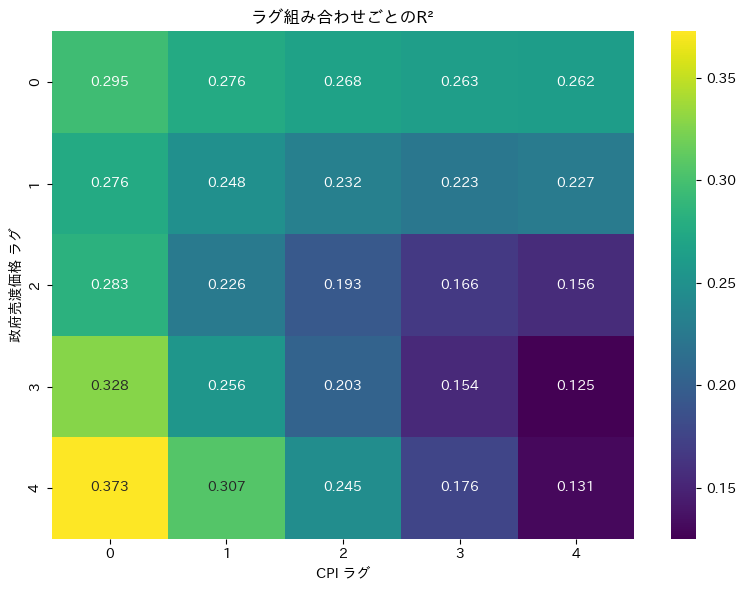

In [42]:
# ======================================================
# 3. 最適なラグの確認：政府売渡価格 × CPI のラグ組み合わせ検証
# ======================================================

# --- ラグ候補（0〜4期）を定義 ---
lags = [0, 1, 2, 3, 4]
results = []  # 結果格納用リスト

# --- 各ラグの組み合わせ（5×5＝25通り）についてループ処理 ---
for gov_lag in lags:

    # --- 政府売渡価格のラグ列を生成（企業ごとにずらす） ---
    col_gov = f"政府売渡価格_lag{gov_lag}"
    if gov_lag == 0:
        df[col_gov] = df["政府売渡価格"]
    else:
        df[col_gov] = df.groupby("企業名")["政府売渡価格"].shift(gov_lag)

    for cpi_lag in lags:
        col_cpi = f"CPI_lag{cpi_lag}"
        if cpi_lag == 0:
            df[col_cpi] = df["CPI"]
        else:
            df[col_cpi] = df.groupby("企業名")["CPI"].shift(cpi_lag)

        # --- 分析用のデータセットを整形（欠損除去＆インデックス指定） ---
        panel = df[[
            "売上総利益率",
            col_gov,
            col_cpi,
            "企業名",
            "四半期_numeric"
        ]].dropna().set_index(["企業名", "四半期_numeric"])

        if panel.empty:
            continue  # 有効なデータがなければスキップ

        # --- PanelOLS モデル構築（企業固定効果あり） ---
        model = PanelOLS.from_formula(
            f"売上総利益率 ~ {col_gov} + {col_cpi} + EntityEffects",
            data=panel,
            check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        # --- 結果を保存（R²と各係数のp値） ---
        results.append({
            "政府_lag": gov_lag,
            "CPI_lag": cpi_lag,
            "R2": res.rsquared,
            "政府_p": res.pvalues.get(col_gov, None),
            "CPI_p": res.pvalues.get(col_cpi, None)
        })

# ======================================================
# 3-1. 結果の整形・出力
# ======================================================

# --- 結果をデータフレーム化し、R²の高い順にソートして表示 ---
results_df = pd.DataFrame(results)
print("=== ラグ組み合わせごとのR²（降順） ===")
print(results_df.sort_values("R2", ascending=False))

# --- CSVとして保存（記録・検証用） ---
results_df.to_csv("出力_ラグ組み合わせ_R2一覧.csv", index=False)

# --- R²のヒートマップを作成・可視化 ---
pivot_r2 = results_df.pivot(index="政府_lag", columns="CPI_lag", values="R2")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="viridis")
plt.title("ラグ組み合わせごとのR²")
plt.xlabel("CPI ラグ")
plt.ylabel("政府売渡価格 ラグ")
plt.tight_layout()

# --- グラフの保存 ---
plt.savefig("出力_ラグ組み合わせ_R2_ヒートマップ.png", dpi=300)
plt.show()


# 3. 最適なラグの確認
- 最も説明力が高いラグは、**政府売渡価格についてラグ4, CPIについてはラグ0である**


===== 【製パン】 spline(df=3) + ラグ固定 gov=4, cpi=0 =====
                          PanelOLS Estimation Summary                           
Dep. Variable:                 売上総利益率   R-squared:                        0.7938
Estimator:                   PanelOLS   R-squared (Between):              0.9932
No. Observations:                 108   R-squared (Within):               0.7938
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.9280
Time:                        07:05:47   Log-likelihood                    322.84
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      76.998
Entities:                           3   P-value                           0.0000
Avg Obs:                       36.000   Distribution:                   F(5,100)
Min Obs:                       36.000                                           
Max Obs:                       36.000   F-statistic (robu

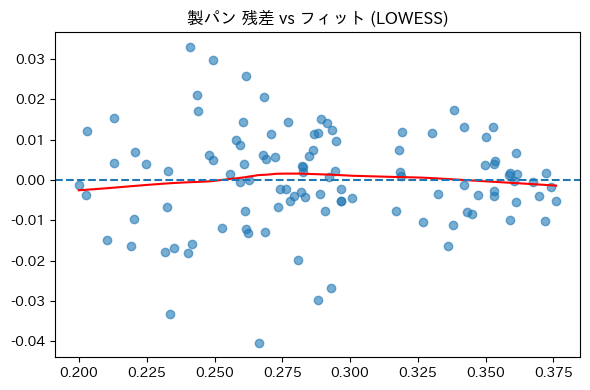

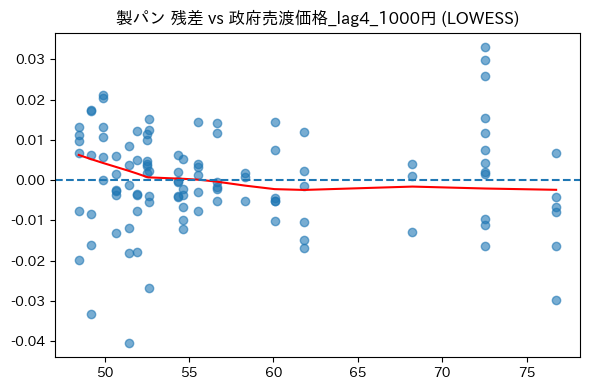

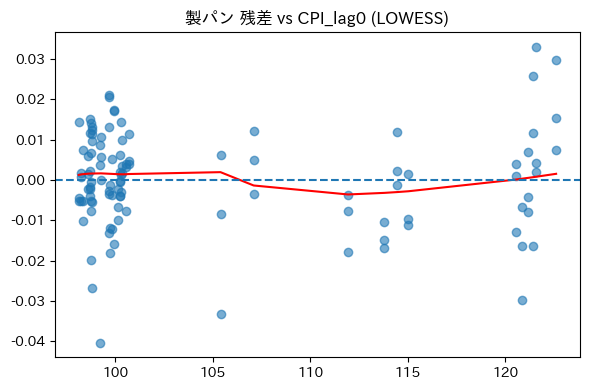

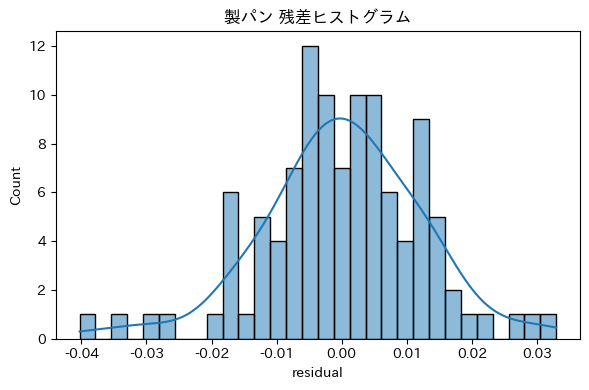

<Figure size 600x300 with 0 Axes>

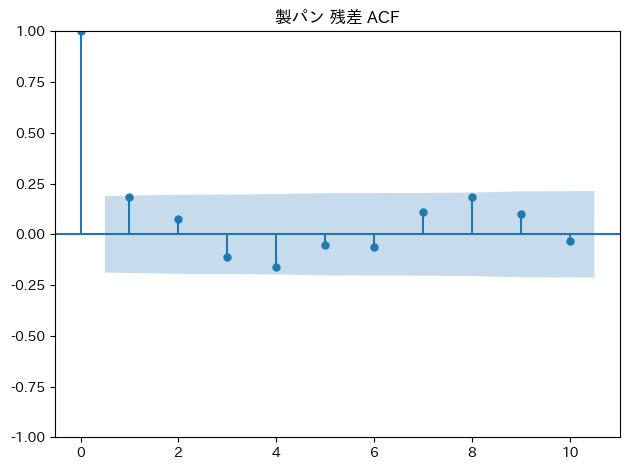


===== 【外食】 spline(df=3) + ラグ固定 gov=4, cpi=0 =====
                          PanelOLS Estimation Summary                           
Dep. Variable:                 売上総利益率   R-squared:                        0.5218
Estimator:                   PanelOLS   R-squared (Between):              0.9965
No. Observations:                 108   R-squared (Within):               0.5218
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.9327
Time:                        07:05:49   Log-likelihood                    382.25
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      21.825
Entities:                           3   P-value                           0.0000
Avg Obs:                       36.000   Distribution:                   F(5,100)
Min Obs:                       36.000                                           
Max Obs:                       36.000   F-statistic (robus

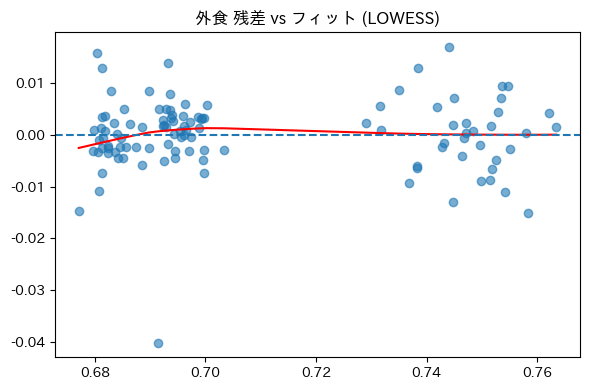

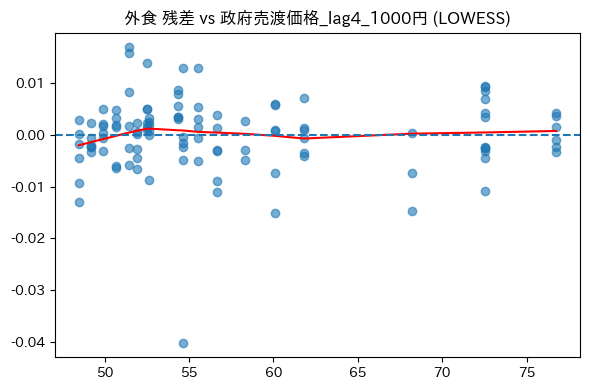

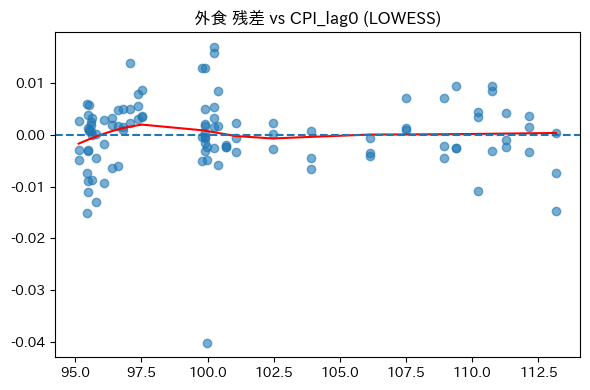

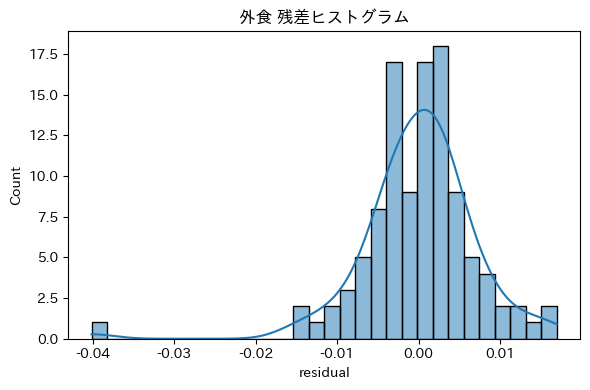

<Figure size 600x300 with 0 Axes>

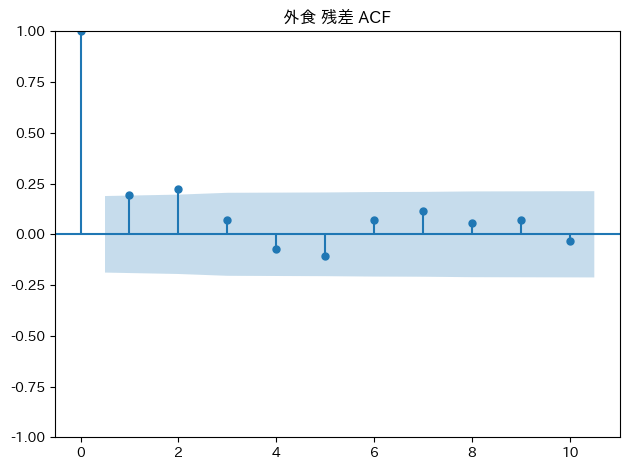

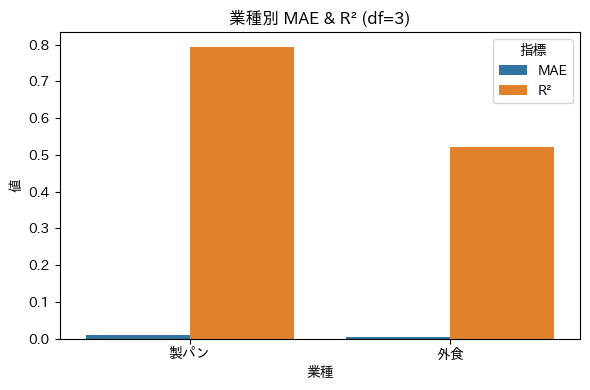

業種別_metrics.csv に評価指標を保存しました。
model_summaries.pkl にモデルサマリーを保存しました。


In [44]:
# ======================================================
# 4. メインモデル：AR主成分1にスプライン(df=3)を適用したパネル回帰分析
# ======================================================

# --- 警告メッセージを非表示（特にRuntimeWarning）
warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- 業種を製パン=0、外食=1としてマッピング
industry_map = {
    "山崎製パン": 0, "第一屋製パン": 0, "日清製粉グループ": 0,
    "王将フードサービス": 1, "トリドールホールディングス": 1, "すかいらーくホールディングス": 1
}
df["業種"] = df["企業名"].map(industry_map)

# --- 結果格納用のリストと辞書を初期化
metrics = []
best_model_summaries = {}

# --- ラグ設定
gov_lag = 4
cpi_lag = 0

# --- 各業種（製パン・外食）ごとにモデルを構築
for sector_name, sector_val in {"製パン": 0, "外食": 1}.items():
    print(f"\n===== 【{sector_name}】 spline(df=3) + ラグ固定 gov={gov_lag}, cpi={cpi_lag} =====")
    df_sector = df[df["業種"] == sector_val].copy()

    # --- 売上総利益率のAR(1)・AR(4)、価格・CPIのラグ変数を作成
    df_sector["売上総利益率_lag1"] = df_sector.groupby("企業名")["売上総利益率"].shift(1)
    df_sector["売上総利益率_lag4"] = df_sector.groupby("企業名")["売上総利益率"].shift(4)
    df_sector[f"政府売渡価格_lag{gov_lag}_1000円"] = df_sector.groupby("企業名")["政府売渡価格"].shift(gov_lag) / 1000
    df_sector[f"CPI_lag{cpi_lag}"] = df_sector.groupby("企業名")["CPI"].shift(cpi_lag)

    # --- 有効な行（AR変数に欠損のないもの）を抽出
    valid_idx = df_sector.dropna(subset=["売上総利益率_lag1", "売上総利益率_lag4"]).index
    if valid_idx.empty:
        print("データ不足でスキップ")
        continue

    # --- AR(1)とAR(4)の主成分分析（PCA）を実施
    ar_std = StandardScaler().fit_transform(df_sector.loc[valid_idx, ["売上総利益率_lag1", "売上総利益率_lag4"]])
    ar_pca = PCA(n_components=2).fit_transform(ar_std)
    df_sector.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

    # --- 有効データの抽出
    df_valid = df_sector.loc[valid_idx].copy()

    # --- AR主成分に対してスプライン基底を生成（自由度=3）
    spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", data=df_valid, return_type="dataframe")
    spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
    spline_basis.index = valid_idx
    df_spline = pd.concat([df_valid, spline_basis], axis=1)

    # --- 説明変数のリストを定義
    predictors = list(spline_basis.columns) + [f"政府売渡価格_lag{gov_lag}_1000円", f"CPI_lag{cpi_lag}"]

    # --- モデル用データの整形
    panel = df_spline[["売上総利益率"] + predictors + ["企業名", "四半期_numeric"]].dropna()
    if panel.empty:
        print("モデルデータ不足でスキップ")
        continue

    panel = panel.set_index(["企業名", "四半期_numeric"])

    # --- 固定効果モデルの構築と推定
    model = PanelOLS.from_formula(f"売上総利益率 ~ {' + '.join(predictors)} + EntityEffects", panel, check_rank=False)
    res = model.fit(cov_type="driscoll-kraay")

    # --- モデルサマリーを表示・保存
    print(res.summary)
    best_model_summaries[sector_name] = res.summary.as_text()
    with open(f"{sector_name}_summary.txt", 'w', encoding='utf-8') as f:
        f.write(best_model_summaries[sector_name])

    # --- モデル評価指標の算出
    actual = panel["売上総利益率"]
    fitted = res.fitted_values.squeeze()
    mae = np.mean(np.abs(actual - fitted))
    r2 = res.rsquared
    dw = durbin_watson(res.resids.squeeze())
    lb_p = acorr_ljungbox(res.resids.squeeze(), lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")
    metrics.append({"業種": sector_name, "MAE": mae, "R²": r2})

    # --- VIFの計算と表示
    vif_X = panel[predictors].copy()
    vif_X = sm.add_constant(vif_X, has_constant="add")
    vif_df = pd.DataFrame({"変数": vif_X.columns, "VIF": [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]})
    vif_df = vif_df[vif_df["変数"] != "const"]
    print("\n【VIF】")
    print(vif_df)

    # --- 残差の可視化（LOWESS, ヒストグラム, ACF）
    residuals = res.resids.squeeze()

    plt.figure(figsize=(6, 4))
    lw = lowess(residuals, fitted)
    plt.scatter(fitted, residuals, alpha=0.6)
    plt.plot(lw[:, 0], lw[:, 1], color="red")
    plt.axhline(0, linestyle="--")
    plt.title(f"{sector_name} 残差 vs フィット (LOWESS)")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_残差_vs_フィット_LOWESS.png", dpi=300)
    plt.show()
    plt.close()

    for pred in [f"政府売渡価格_lag{gov_lag}_1000円", f"CPI_lag{cpi_lag}"]:
        plt.figure(figsize=(6, 4))
        lw = lowess(residuals, panel[pred])
        plt.scatter(panel[pred], residuals, alpha=0.6)
        plt.plot(lw[:, 0], lw[:, 1], color="red")
        plt.axhline(0, linestyle="--")
        plt.title(f"{sector_name} 残差 vs {pred} (LOWESS)")
        plt.tight_layout()
        plt.savefig(f"{sector_name}_残差_vs_{pred}_LOWESS.png", dpi=300)
        plt.show()
        plt.close()

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{sector_name} 残差ヒストグラム")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_残差ヒストグラム.png", dpi=300)
    plt.show()
    plt.close()

    plt.figure(figsize=(6, 3))
    plot_acf(residuals, lags=10)
    plt.title(f"{sector_name} 残差 ACF")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_残差ACF.png", dpi=300)
    plt.show()
    plt.close()

# --- 評価指標（MAE・R^2）の業種別可視化と保存
if metrics:
    df_metrics = pd.DataFrame(metrics)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_metrics.melt(id_vars="業種", var_name="指標", value_name="値"), x="業種", y="値", hue="指標")
    plt.title("業種別 MAE & R² (df=3)")
    plt.tight_layout()
    plt.savefig('業種別_MAE_R2_df3.png', dpi=300)
    plt.show()
    plt.close()

    df_metrics.to_csv('業種別_metrics.csv', index=False, encoding='utf-8-sig')
    print("業種別_metrics.csv に評価指標を保存しました。")

    joblib.dump({k: v for k, v in best_model_summaries.items()}, 'model_summaries.pkl')
    print("model_summaries.pkl にモデルサマリーを保存しました。")



# 4. メインモデル 結果


---


## モデル概要
- **モデル形式**: 固定効果付きパネル回帰 (PanelOLS, EntityEffects)
- **サンプル数**: 108社 (各業種3社 × 36期間)
- **観測期間**: 各社36期間
- **採用ラグ**: 政府売渡価格 = lag4、CPI = lag0
- **スプライン自由度**: df=3 (AR主成分)


---


## 主な統計指標
| 指標                  | 製パン    | 外食     |
|-----------------------|-----------|----------|
| R²（決定係数）         | 0.7938    | 0.5218   |
| MAE（平均絶対誤差）    | 0.0097    | 0.004915   |
| DW（残差の自己相関）   | 1.6300    | 1.620   |
| LB検定 p値            | 0.0950    | 0.1175   |
| モデル有意性 p値       | 0.0000    | 0.0000   |


## パラメータ推定値-製パン
| 変数名                    | 係数     | 標準誤差   | t値     | P値     | 有意性     | 解釈例                       |
|--------------------------|---------|-----------|---------|---------|-----------|-------------------------------|
| AR_spline1               | 0.3837  | 0.0364    | 10.54   | 0.0000  | ***       | ラグ系列（非線形）主成分影響    |
| AR_spline2               | -0.0592 | 0.0202    | -2.93   | 0.0042  | **        | 同上                          |
| AR_spline3               | -0.1337 | 0.0245    | -5.45   | 0.0000  | ***       | 同上                          |
| AR_spline4               | -0.1685 | 0.0197    | -8.55   | 0.0000  | ***       | 同上                          |
| 政府売渡価格_lag4_1000円 | 0.0014  | 0.0003    | 5.11    | 0.0000   | ***       | 1,000円上昇で利益率+0.14pt     |
| CPI_lag0                 | -0.0009 | 0.0005    | -1.78   | 0.0775  |           | CPI1単位上昇で利益率-0.09pt     |

## パラメータ推定値-外食 
| 変数名                    | 係数     | 標準誤差   | t値    | P値     | 有意性 | 解釈例                          |
|---------------------------|----------|------------|--------|---------|--------|------------------------------|
| AR_spline1                | 0.7236   | 0.0435     | 16.631  | 0.0000  | ***  | ラグ系列（非線形）主成分影響    |
| AR_spline2                | -0.0046  | 0.0265     | -0.1743  | 0.8620 |      | 同上                          |
| AR_spline3                | 0.0623   | 0.0204     | 3.0580  | 0.0029  |  **  | 同上                          |
| AR_spline4                | 0.0834   | 0.0116     | 7.1967  | 0.0000  | ***  | 同上                          |
| 政府売渡価格_lag4_1000円  | 0.0002    | 0.0001     | 2.0617  | 0.0418  | *    | 1,000円上昇で利益率+0.02pt     |
| CPI_lag0                  | -0.0006  | 0.0004     | -1.4477 | 0.1508  |      | CPI1単位上昇で利益率-0.06pt    |

- 有意性: ***p<0.001, **p<0.01, *p<0.05


---


## モデル解釈のポイント - 製パン

- **政府売渡価格_lag4_1000円の係数0.0014は「1,000円上昇ごとに売上総利益率+0.14pt」**
- **CPI(影響は弱い（p=0078、統計的には参考値）**
- **残差に強い自己相関・多重共線性なし**
- **モデル全体の説明力は極めて高い（R² = 0.79）**


## モデル解釈のポイント - 外食

- **外食業において、「政府売渡価格」は統計的に有意な説明変数だが、モデル全体の説明力は約5割と製パン業より低い**
- **他要因による影響が大きい可能性を示唆**


---



## AR主成分＋スプライン採用の理由

### なぜAR(1)項とAR(4)項を選択したか

- AR(1)：直近（1期前）の売上総利益率の影響を捉えるため  
  → 多くの経済系列では直近の値が将来値に強く影響を与える。
- AR(4)：1年前と同じ四半期の影響（最季節性）を捉えるため  
  → 日本企業の四半期決算では「季節パターン（前年同期比）」の影響が大きい。
- この2つのラグのみ採用することで、「短期的な連続性」と「季節的要因」を小限に留めている。

### なぜ主成分分析（PCA）を使ったか

- AR(1)とAR(4)は互いに相関しやすく、多重共線性を招きやすい。
- 主成分分析で「過去系列の共通パターン」を1つの主成分に要約することで、ノイズや冗長性を減らし、モデルの安定性・解釈性を向上させるため。
- 主成分化することで、後述のスプライン変換もスムーズに適用できる。

### なぜスプライン変換を加えたか

- 時系列主成分関係が「単純な直線」でない可能性が高い。
  - たとえば「ある水準を超えると効果が急変する」「効果が緩やかに変化する」など。
- スプライン基底関数で変換することで、「非線形な関係」も柔軟にモデル化できる。
- これにより、**過去の系列パターンがどのような形で現状利益率に影響するか**を捉えられる。


---


## コメント

- **政府売渡価格が企業の売上総利益率に対して、統計的に有意な影響**を与えていることが分かった。よって、**帰無仮説1は棄却できる**と判断。
- ただし、政府売渡価格が売上総利益率に**正の影響**を与えているということは想定していなかった。
- 今回のモデルはR²が最も高いラグ（政府売渡価格_lag4, CPI_lag0）を選定したことから、**企業は政府売渡価格が決定して1年の間に価格転嫁を行った可能性がある**。
- 企業のダイナミクスを把握するため、政府売渡価格やCPIの係数としての推移を確認するモデルを組む。

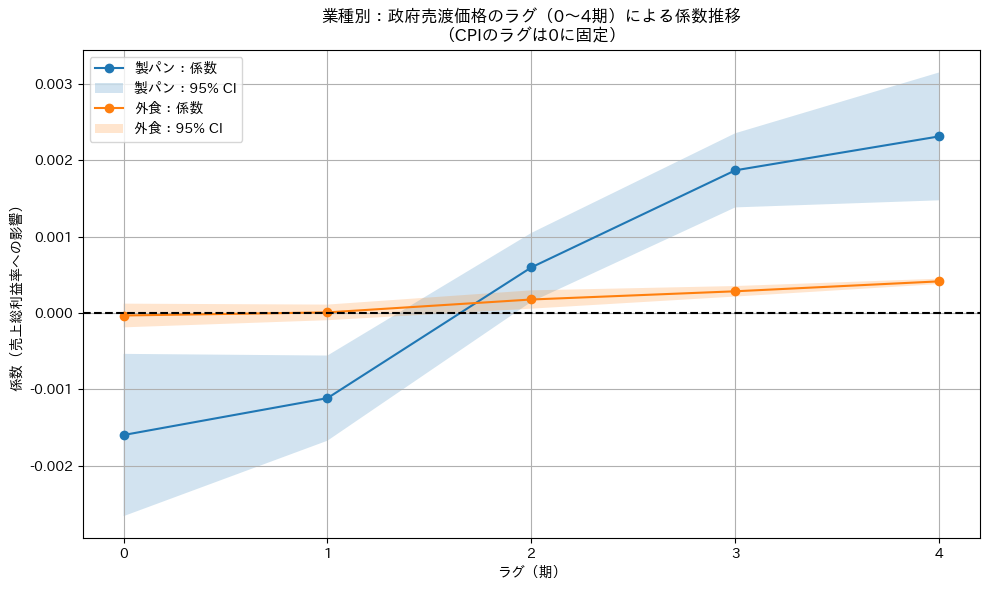

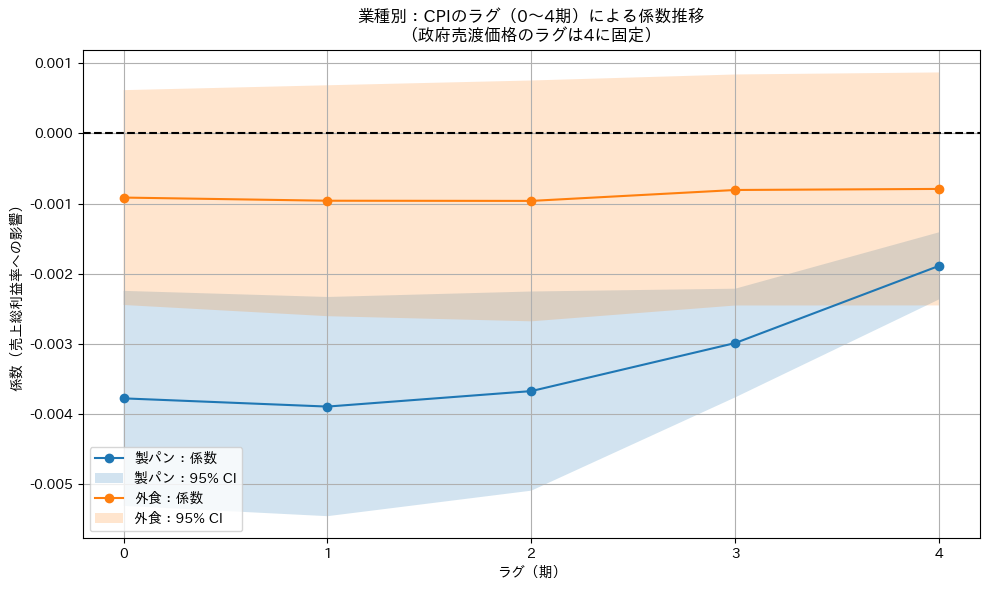

In [54]:
# ======================================================
# 5. ラグに伴う係数の推移（政府売渡価格・CPI）
# ======================================================

# --- 業種マッピング（製パン:0、外食:1） ---
industry_map = {
    "山崎製パン": 0, "第一屋製パン": 0, "日清製粉グループ": 0,
    "王将フードサービス": 1, "トリドールホールディングス": 1, "すかいらーくホールディングス": 1
}
df["業種"] = df["企業名"].map(industry_map)

lags = [0, 1, 2, 3, 4]

# ======================================================
# 1. 政府売渡価格のラグによる係数推移（CPIラグは0に固定）
# ======================================================
sector_results_gov = {}

for sector_name, sector_value in {"製パン": 0, "外食": 1}.items():
    coef_list, ci_lower_list, ci_upper_list = [], [], []
    df_sector = df[df["業種"] == sector_value].copy()

    for lag in lags:
        # 政府売渡価格のラグ変数
        col_gov = f"政府売渡価格_lag{lag}_1000円"
        df_sector[col_gov] = (
            df_sector.groupby("企業名")["政府売渡価格"].shift(lag) / 1000
            if lag != 0 else df_sector["政府売渡価格"] / 1000
        )
        
        # CPIはラグ0で固定
        df_sector["CPI_lag0"] = df_sector["CPI"]

        # モデル構築用データ整形
        panel = df_sector[[
            "売上総利益率", col_gov, "CPI_lag0", "企業名", "四半期_numeric"
        ]].dropna().set_index(["企業名", "四半期_numeric"])

        if panel.empty:
            coef_list.append(np.nan)
            ci_lower_list.append(np.nan)
            ci_upper_list.append(np.nan)
            continue

        model = PanelOLS.from_formula(
            f"売上総利益率 ~ {col_gov} + CPI_lag0 + EntityEffects",
            data=panel, check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        coef, std = res.params[col_gov], res.std_errors[col_gov]
        coef_list.append(coef)
        ci_lower_list.append(coef - 1.96 * std)
        ci_upper_list.append(coef + 1.96 * std)

    sector_results_gov[sector_name] = {
        "coef": coef_list, "ci_lower": ci_lower_list, "ci_upper": ci_upper_list
    }

# --- 可視化と保存：政府売渡価格ラグの係数推移 ---
plt.figure(figsize=(10, 6))
for sector_name, result in sector_results_gov.items():
    plt.plot(lags, result["coef"], marker='o', label=f'{sector_name}：係数')
    plt.fill_between(lags, result["ci_lower"], result["ci_upper"], alpha=0.2, label=f'{sector_name}：95% CI')

plt.axhline(0, color='black', linestyle='--')
plt.title("業種別：政府売渡価格のラグ（0〜4期）による係数推移\n（CPIのラグは0に固定）")
plt.xlabel("ラグ（期）")
plt.ylabel("係数（売上総利益率への影響）")
plt.xticks(lags)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("出力_政府売渡価格ラグ_係数推移.png", dpi=300)
plt.show()

# ======================================================
# 2. CPIのラグによる係数推移（政府売渡価格ラグは4に固定）
# ======================================================
sector_results_cpi = {}

for sector_name, sector_value in {"製パン": 0, "外食": 1}.items():
    coef_list, ci_lower_list, ci_upper_list = [], [], []
    df_sector = df[df["業種"] == sector_value].copy()

    for lag in lags:
        # CPIのラグ変数
        col_cpi = f"CPI_lag{lag}"
        df_sector[col_cpi] = (
            df_sector.groupby("企業名")["CPI"].shift(lag)
            if lag != 0 else df_sector["CPI"]
        )
        
        # 政府売渡価格はラグ4で固定
        df_sector["政府売渡価格_lag4_1000円"] = df_sector.groupby("企業名")["政府売渡価格"].shift(4) / 1000

        # モデル構築用データ整形
        panel = df_sector[[
            "売上総利益率", "政府売渡価格_lag4_1000円", col_cpi, "企業名", "四半期_numeric"
        ]].dropna().set_index(["企業名", "四半期_numeric"])

        if panel.empty:
            coef_list.append(np.nan)
            ci_lower_list.append(np.nan)
            ci_upper_list.append(np.nan)
            continue

        model = PanelOLS.from_formula(
            f"売上総利益率 ~ 政府売渡価格_lag4_1000円 + {col_cpi} + EntityEffects",
            data=panel, check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        coef, std = res.params[col_cpi], res.std_errors[col_cpi]
        coef_list.append(coef)
        ci_lower_list.append(coef - 1.96 * std)
        ci_upper_list.append(coef + 1.96 * std)

    sector_results_cpi[sector_name] = {
        "coef": coef_list, "ci_lower": ci_lower_list, "ci_upper": ci_upper_list
    }

# --- 可視化と保存：CPIラグの係数推移 ---
plt.figure(figsize=(10, 6))
for sector_name, result in sector_results_cpi.items():
    plt.plot(lags, result["coef"], marker='o', label=f'{sector_name}：係数')
    plt.fill_between(lags, result["ci_lower"], result["ci_upper"], alpha=0.2, label=f'{sector_name}：95% CI')

plt.axhline(0, color='black', linestyle='--')
plt.title("業種別：CPIのラグ（0〜4期）による係数推移\n（政府売渡価格のラグは4に固定）")
plt.xlabel("ラグ（期）")
plt.ylabel("係数（売上総利益率への影響）")
plt.xticks(lags)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("出力_CPIラグ_係数推移.png", dpi=300)
plt.show()

# 4. ラグに伴う係数の推移 結果
## 政府売渡価格について                                                                          
- **製パンと外食では、政府売渡価格に関する影響の感応度が異なる。(帰無仮説2は棄却できる？)→厳密には業種単位で交差項を組む必要**
- **製パンでは、ラグ0, 1では売上総利益率の悪化があり、その後価格転嫁が進み、利益率が改善するという流れ**
- **外食では、政府売渡価格の変化は製パンと比較して企業の利益率に対する影響が小さい**


---


## CPIについて
- CPIは、即時効果が強く、徐々に回復
- 影響は製パンのほうが大きい


                          PanelOLS Estimation Summary                           
Dep. Variable:                 売上総利益率   R-squared:                        0.7521
Estimator:                   PanelOLS   R-squared (Between):              0.9878
No. Observations:                 216   R-squared (Within):               0.7521
Date:                Wed, Jun 11 2025   R-squared (Overall):              0.9857
Time:                        04:22:07   Log-likelihood                    686.15
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      103.13
Entities:                           6   P-value                           0.0000
Avg Obs:                       36.000   Distribution:                   F(6,204)
Min Obs:                       36.000                                           
Max Obs:                       36.000   F-statistic (robust):             107.24
                            

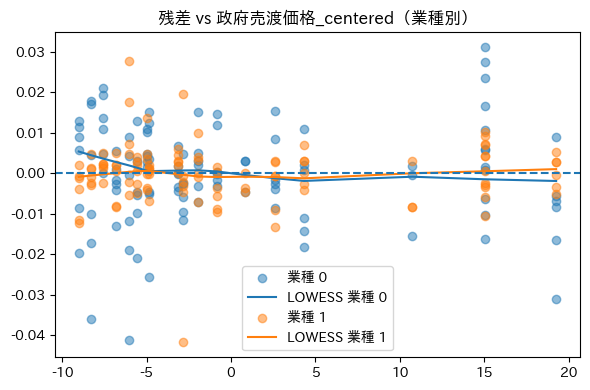

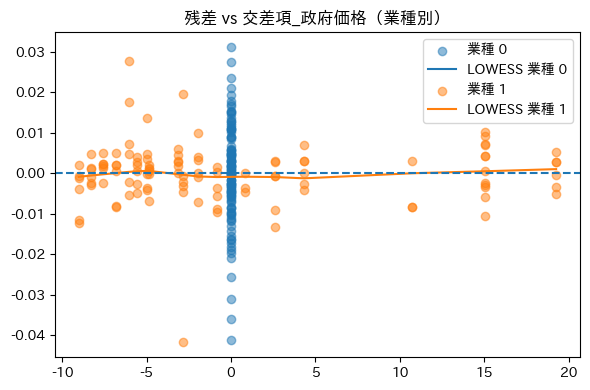

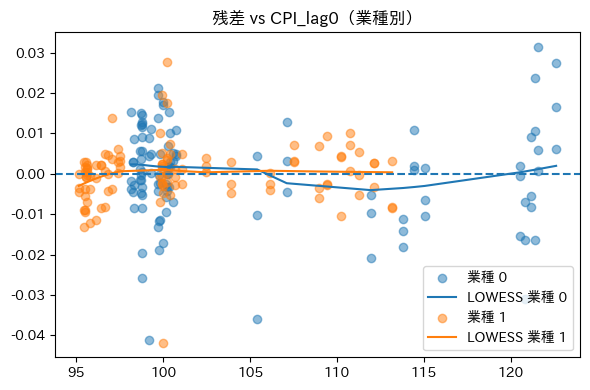

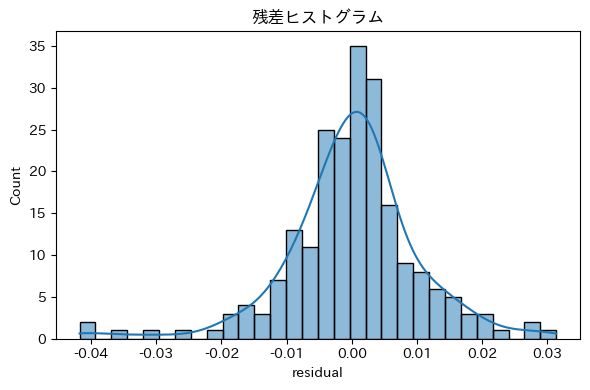

<Figure size 600x300 with 0 Axes>

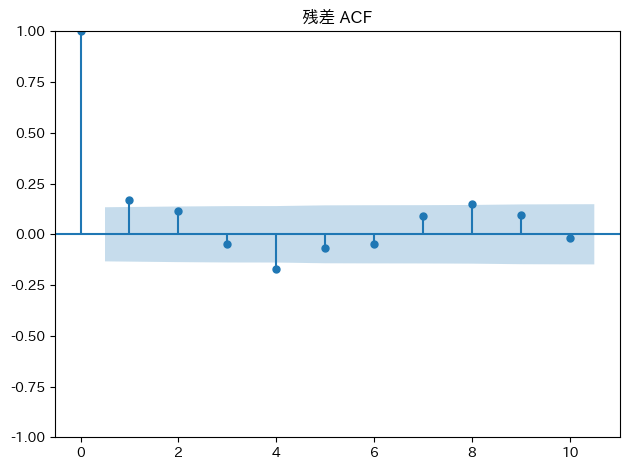

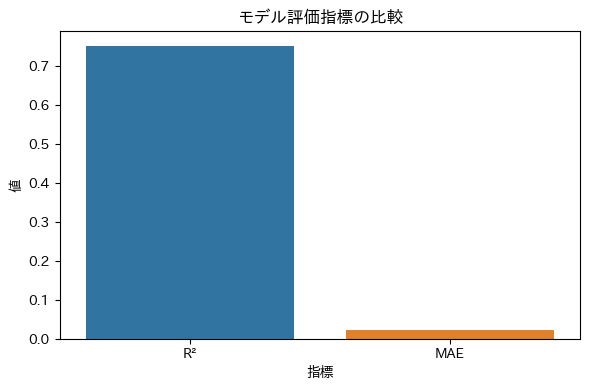

In [3]:
# ======================================================
# 6. 交差項モデル（モデルサマリ保存対応版）
# ======================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from linearmodels.panel import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- 業種マッピング ---
industry_map = {
    "山崎製パン": 0, "第一屋製パン": 0, "日清製粉グループ": 0,
    "王将フードサービス": 1, "トリドールホールディングス": 1, "すかいらーくホールディングス": 1
}
df["業種"] = df["企業名"].map(industry_map)

# --- ラグ作成 ---
gov_lag, cpi_lag = 4, 0
_df = df.copy()
_df["売上総利益率_lag1"] = _df.groupby("企業名")["売上総利益率"].shift(1)
_df["売上総利益率_lag4"] = _df.groupby("企業名")["売上総利益率"].shift(4)
_df[f"政府売渡価格_lag{gov_lag}_1000円"] = _df.groupby("企業名")["政府売渡価格"].shift(gov_lag) / 1000
_df[f"CPI_lag{cpi_lag}"] = _df.groupby("企業名")["CPI"].shift(cpi_lag)

# --- 主成分分析（AR項） ---
valid_idx = _df.dropna(subset=["売上総利益率_lag1", "売上総利益率_lag4"]).index
ar_std = StandardScaler().fit_transform(_df.loc[valid_idx, ["売上総利益率_lag1", "売上総利益率_lag4"]])
ar_pca = PCA(n_components=2).fit_transform(ar_std)
_df.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

# --- スプライン展開 ---
spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", 
                       data=_df.loc[valid_idx], return_type="dataframe")
spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
spline_basis.index = valid_idx
_df = pd.concat([_df, spline_basis], axis=1)

# --- 政府売渡価格の中心化と交差項作成 ---
_df["政府売渡価格_centered"] = _df[f"政府売渡価格_lag{gov_lag}_1000円"] - _df[f"政府売渡価格_lag{gov_lag}_1000円"].mean()
_df["業種ダミー"] = _df["業種"]
_df["交差項_政府価格"] = _df["政府売渡価格_centered"] * _df["業種ダミー"]

# --- モデル用データ整形 ---
predictors = list(spline_basis.columns) + ["政府売渡価格_centered", "交差項_政府価格", f"CPI_lag{cpi_lag}"]
cols = ["売上総利益率"] + predictors + ["企業名", "四半期_numeric", "業種"]
panel = _df[cols].dropna().set_index(["企業名", "四半期_numeric"])

# --- パネル回帰 ---
formula = f"売上総利益率 ~ {' + '.join(predictors)} + EntityEffects"
model = PanelOLS.from_formula(formula, panel)
res = model.fit(cov_type="driscoll-kraay")

# モデルサマリをテキストファイルに保存
with open("共通モデル_summary.txt", "w", encoding="utf-8") as f:
    f.write(str(res.summary))

# コンソールにも出力
print(res.summary)

# --- モデル指標 ---
actual    = panel["売上総利益率"]
fitted    = res.fitted_values.squeeze()
residuals = res.resids.squeeze()
mae = np.mean(np.abs(actual - fitted))
r2  = res.rsquared
dw  = durbin_watson(residuals)
lb_p= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")

# --- VIF計算 ---
vif_X = panel[predictors].copy()
vif_X = sm.add_constant(vif_X, has_constant="add")
vif_df = pd.DataFrame({
    "変数": vif_X.columns,
    "VIF": [variance_inflation_factor(vif_X.values, i) 
            for i in range(vif_X.shape[1])]
})
vif_df = vif_df[vif_df["変数"] != "const"]
print("\n【VIF】")
print(vif_df)

# --- 残差LOWESSプロット（業種別） ---
for pred in ["政府売渡価格_centered", "交差項_政府価格", f"CPI_lag{cpi_lag}"]:
    plt.figure(figsize=(6, 4))
    for label, group in panel.groupby("業種"):
        lw = sm.nonparametric.lowess(residuals[group.index], group[pred])
        plt.scatter(group[pred], residuals[group.index], alpha=0.5, label=f'業種 {label}')
        plt.plot(lw[:, 0], lw[:, 1], label=f'LOWESS 業種 {label}')
    plt.axhline(0, linestyle="--")
    plt.title(f"残差 vs {pred}（業種別）")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"共通モデル_残差vs_{pred}_業種別.png", dpi=300)
    plt.show()
    plt.close()

# --- 残差ヒストグラム ---
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("残差ヒストグラム")
plt.tight_layout()
plt.savefig("共通モデル_残差ヒストグラム.png", dpi=300)
plt.show()
plt.close()

# --- 残差ACFプロット ---
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(6, 3))
plot_acf(residuals, lags=10)
plt.title("残差 ACF")
plt.tight_layout()
plt.savefig("共通モデル_残差ACF.png", dpi=300)
plt.show()
plt.close()

# --- R²とMAEの比較棒グラフ ---
plt.figure(figsize=(6, 4))
metrics_df = pd.DataFrame({"指標": ["R²", "MAE"], "値": [r2, mae]})
sns.barplot(data=metrics_df, x="指標", y="値")
plt.title("モデル評価指標の比較")
plt.tight_layout()
plt.savefig("共通モデル_指標比較.png", dpi=300)
plt.show()
plt.close()


# 6. 交差項モデル 結果


---


## モデル概要
- **モデル形式**: 固定効果付きパネル回帰 (PanelOLS, EntityEffects)
- **サンプル数**: 216社 (6社 × 36期間)
- **観測期間**: 各社36期間
- **採用ラグ**: 政府売渡価格 = lag4、CPI = lag0
- **スプライン自由度**: df=3 (AR主成分)


---


## 主な統計指標
| 指標                  | 数値    |
|-----------------------|-----------|
| R²（決定係数）         | 0.7521   |
| MAE（平均絶対誤差）    | 0.023254 |
| DW（残差の自己相関）   | 1.659    |
| LB検定 p値            | 0.0030   |
| モデル有意性 p値       | 0.0000    |


## パラメータ推定値-製パン
| 変数名                    | 係数     | 標準誤差   | t値     | P値     | 有意性     | 解釈例                         |
|--------------------------|---------|-----------|---------|---------|-----------|---------------------------------|
| AR_spline1               | 0.8354  | 0.0348    | 23.981    | 0.0000  | ***       | ラグ系列（非線形）主成分影響     |
| AR_spline2               | -0.1275 | 0.0359    | -3.5526   | 0.0005  | ***       | 同上                           |
| AR_spline3               | -0.4378 | 0.0810    | -5.4049   | 0.0000  | ***       | 同上                           |
| AR_spline4               | -0.5979 | 0.0720    | -8.3023   | 0.0000  | ***       | 同上                           |
| 政府売渡価格_centered     | 0.0012  | 0.0003    | 4.8452    | 0.0000  | ***       | 1,000円上昇で利益率+0.12pt      |
| 交差項_政府価格           | -0.0008 | 0.0003    | -3.0834   | 0.0023  | **        | 外食企業のほうが、0.08%感応度が小 |
| CPI_lag0                 | -0.0006 | 0.0003    | -1.9732   | 0.0498  | *         | CPI1単位上昇で利益率-0.06pt      |


- 有意性: ***p<0.001, **p<0.01, *p<0.05


---


## モデル解釈のポイント

- **交差項_業種価格は製パンと外食の政府売渡価格の変化に対する売上総利益率の感応度を示す(p値=0.0023)**
- 政府売渡価格_centeredは製パンの感応度、交差項_政府価格は外食の感応度
- **CPIの影響は弱い（p=0.0498、統計的には有意）**
- **モデル全体の説明力は高い（R² = 0.75）**


---


## 政府売渡価格_centered について

- **目的**：売上総利益率に対する政府売渡価格の感応度（弾力性）を、業種間で比較可能な形で明らかにす。


- **方法**：
  - 政府売渡価格_lag4 を全体で平均し、そこからの偏差を算出（中心化）。
  - `政府売渡価格_centered = 政府売渡価格_lag4 - 平均(政府売渡価格_lag4)`

- **背景と必要性**：
  - 政府売渡価格の水準が業種間で異なると、交差項（業種 × 政府価格）にも水準のズレが反映されてしまう。
  - 中心化しない場合、係数には「感応度」と「価格水準の差」の両方が混在し、解釈が困難になる。

- **中心化の効果**：
  - 交差項の係数が、業種間の純粋な傾きの差（感応度の差）を表すようになる。
  - 多重共線性の緩和により、推定結果が安定。
  - 定数項（切片）は、政府売渡価格が平均値のときの基準業種（製パン）の売上総利益率を示す
---

ため、解釈が直感的になる。業種交差項コメント

- **政府売渡価格が企業の売上総利益率に対して、統計的に有意な影響**を与えていること2分かった。よって、**帰無仮説製パン企業のほうが、外食企業よりも、政府売渡価格に対する感応度は高い。
- ただし、売上総利益率は前期及び1年前の売上総利益率に大きく影響されている。(**恒常性と季節性がある**)
- そのため、売上総総利は構造として**の推移を確認するモデルを組む。